# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [ ]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 155 (delta 52), reused 123 (delta 26), pack-reused 0
Receiving objects: 100% (155/155), 6.48 MiB | 24.47 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [ ]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [ ]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
    nn.Linear(D_i,D_k),
    nn.ReLU(),
    nn.Linear(D_k,D_k),
    nn.ReLU(),
    nn.Linear(D_k,D_o))





def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  #print("Initializing layer")
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform(layer_in.weight)
    layer_in.bias.data.fill_(0.0)


# Call the function you just defined
model.apply(weights_init)


<ipython-input-10-cb7bbc1940e2>:25: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer_in.weight)


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

AttributeError: ignored

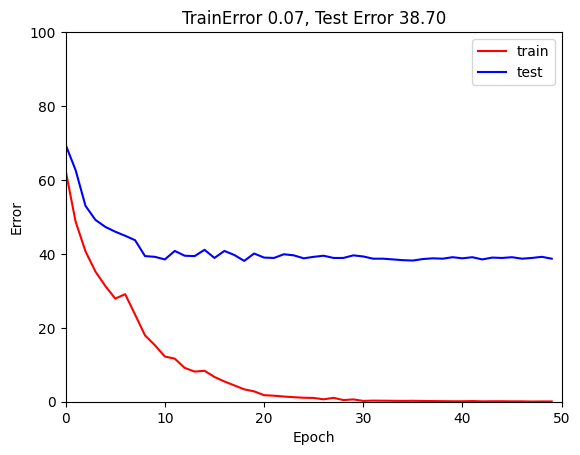

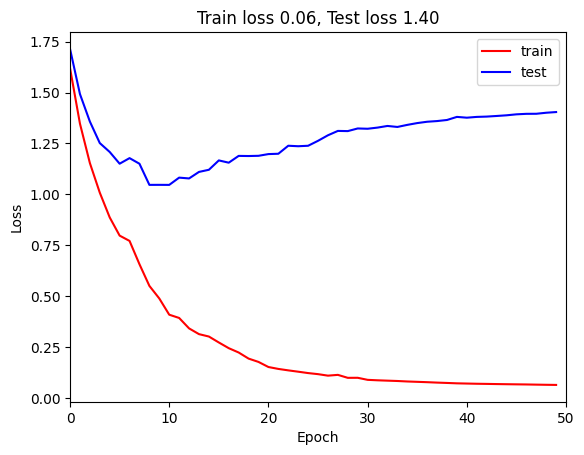

In [ ]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

In [2]:
# Repeat teh above using the Flax

from flax import linen as nn
import jax.nn.initializers as initializers
import jax


class SimpleClassifier(nn.Module):
  num_hidden : int
  num_output :int

  @nn.compact
  def __call__(self, x):
      return nn.Sequential([nn.Dense(num_hidden, kernel_init=initializers.kaiming_uniform(), bias_init=initializers.zeros),
                     nn.relu,
                     nn.Dense(num_hidden, kernel_init=initializers.kaiming_uniform(), bias_init=initializers.zeros),
                     nn.relu,
                     nn.Dense(num_output,kernel_init=initializers.kaiming_uniform(), bias_init=initializers.zeros)])(x)

num_hidden= 100 # D_k
num_output = 10 # D_o

model = SimpleClassifier(num_hidden=num_hidden,num_output= num_output)
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 100
    num_output = 10
)


In [3]:

rng = jax.random.PRNGKey(0)

fake_batch_data_rng, init_rng = jax.random.split(rng,num=2)

input_size = 40 # D_i
batch_size = 100

fake_batch_data = jax.random.normal(fake_batch_data_rng,(batch_size,input_size))

params = model.init(init_rng,fake_batch_data)


In [4]:
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

{'params': {'Dense_0': {'bias': (100,), 'kernel': (40, 100)},
  'Dense_1': {'bias': (100,), 'kernel': (100, 100)},
  'Dense_2': {'bias': (10,), 'kernel': (100, 10)}}}

In [5]:
# data
!git clone https://github.com/greydanus/mnist1d

import mnist1d
args = mnist1d.data.get_dataset_args()
mnist1d_dataset = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(mnist1d_dataset['y'])))
print("Examples in test set: {}".format(len(mnist1d_dataset['y_test'])))
print("Length of each example: {}".format(mnist1d_dataset['x'].shape[-1]))


fatal: destination path 'mnist1d' already exists and is not an empty directory.
Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class mnist1d_data(Dataset):
  def __init__(self, x, y, batch_size = 32):
    self.x =x
    self.y = y
    self.batch_size = batch_size
  def __len__(self):
    return len(self.x)


  def __getitem__(self, index):

    return self.x[index].astype(np.float32), self.y[index].astype(np.float32)


mni= mnist1d_data(mnist1d_dataset['x'],mnist1d_dataset['y'])


def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


dataloader = DataLoader(mni, batch_size=batch_size, shuffle=True, collate_fn = numpy_collate)




In [8]:
inputs, labels = next(iter(dataloader))

print(labels)

[8. 9. 8. 5. 3. 0. 3. 3. 0. 7. 9. 3. 1. 1. 7. 5. 9. 7. 4. 5. 5. 5. 5. 8.
 6. 0. 4. 2. 7. 7. 4. 9. 8. 7. 4. 7. 7. 6. 8. 2. 1. 3. 6. 8. 9. 5. 4. 0.
 2. 8. 2. 7. 1. 7. 2. 3. 5. 3. 2. 6. 7. 1. 4. 4. 9. 1. 9. 2. 6. 4. 4. 6.
 9. 0. 8. 9. 5. 9. 2. 1. 7. 1. 0. 6. 4. 5. 2. 5. 7. 9. 6. 1. 7. 6. 2. 6.
 8. 5. 8. 9.]


In [9]:
out_test = model.apply(params,inputs)
out_test



Array([[ 3.79413700e+00,  1.02890110e+00,  1.27259731e+00,
         8.10866892e-01, -1.43801546e+00,  1.08105612e+00,
         1.13359523e+00,  9.49152946e-01, -4.76714134e-01,
        -2.01023483e+00],
       [ 1.65738380e+00,  8.95730853e-02, -1.03440619e+00,
         1.70086551e+00, -1.71519721e+00, -4.10088122e-01,
         3.68253231e-01,  1.03758740e+00, -6.05867386e-01,
        -3.31172705e+00],
       [ 2.62713218e+00,  4.65720266e-01, -4.85425711e-01,
         8.18913639e-01, -1.51081324e+00,  2.17415214e-01,
         1.42182612e+00,  1.92724955e+00, -2.53611040e+00,
        -3.63695025e+00],
       [ 4.10858345e+00,  1.59564257e-01,  3.43120098e-01,
        -3.17590863e-01, -1.71548009e+00,  8.53480101e-01,
         1.89714789e+00,  1.33499712e-01, -9.03472304e-01,
        -3.42100906e+00],
       [ 2.10630441e+00, -7.36036003e-01,  1.73244429e+00,
         4.10937428e-01, -7.58185863e-01,  1.68069291e+00,
         1.49677861e+00,  1.94761002e+00, -4.66675833e-02,
        -1.

In [10]:
import optax

# Input to the optimizer are optimizer settings like learning rate, momentum
lr = 0.05
mom = 0.9

optimizer = optax.sgd(learning_rate=lr, momentum = mom)


In [11]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)


In [15]:
def CrossEntropyLoss(state,params, batch,num_labels):
  input_data, labels = batch
  logits = state.apply_fn(params, input_data)
  one_hot_label = jax.nn.one_hot(labels, num_classes=num_labels)

  return optax.softmax_cross_entropy(logits, one_hot_label).sum().mean()


In [16]:
num_labels = 10

CrossEntropyLoss(model_state,params, (inputs,labels),num_labels)

Array(323.47327, dtype=float32)

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(CrossEntropyLoss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, batch,num_labels)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [ ]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc


In [ ]:
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [ ]:
from flax.training import checkpoints

checkpoints.save_checkpoint(ckpt_dir='my_checkpoints/',  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

In [ ]:
loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir='my_checkpoints/',   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='my_model'  # Checkpoint file name prefix
                                            )

In [ ]:
test_dataset = mnist1d_data(mnist1d_dataset['x_test'],mnist1d_dataset['y_test'])
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)



In [ ]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")


In [ ]:
trained_model = model.bind(trained_model_state.params)
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape
